In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| default_exp search

In [3]:
#| export
import sys
sys.path.insert(0,'..')
from mytools.tools import *
from food.paths import *
from food.psql import *
import requests
import torch
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance,ImageOps
from food.paths import *
# from stego.segment import get_food_segment
from segmentor.segment import *

from mytools.visual import *
from food.depth import *

from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cv2
import numpy as np
from matplotlib import pyplot as plt

dev


In [4]:
#| export
def apply_custom_colormap(image_gray, cmap):

    assert image_gray.dtype == np.uint8, 'must be np.uint8 image'

    # Initialize the matplotlib color map
    sm = plt.cm.ScalarMappable(cmap=cmap)

    # Obtain linear color range
    color_range = sm.to_rgba(np.linspace(0, 1, 256))[:,0:3]    # color range RGBA => RGB
    color_range = (color_range*255.0).astype(np.uint8)         # [0,1] => [0,255]
    # color_range = np.squeeze(np.dstack([color_range[:,2], color_range[:,1], color_range[:,0]]), 0)  # RGB => BGR

    # Apply colormap for each channel individually
    channels = [cv2.LUT(image_gray, color_range[:,i]) for i in range(3)]
    return np.dstack(channels)

In [5]:
#| export
def get_heatmap(arr,
                colors = ["white","lime","green","yellow","orange", "red","purple","purple","purple","purple","purple","purple"],
                values = [0,           1,     50,     100,     200,   300,     400,     500,     600,     700,     800,     900]):
    
    l = list(zip([v/max(values) for v in values],colors))
    cmap=LinearSegmentedColormap.from_list('hmap',l)
    return apply_custom_colormap((np.array(arr)/max(values)*255).astype(np.uint8),cmap)
    

In [6]:
#| export
def blend_array2img(img,arr,alphas = [0.5,0.5]):
    return cv2.addWeighted(arr, alphas[0], np.array(img).astype(np.uint8), alphas[1], 0)

In [7]:
#| export
bad_cats  = ['Vegetables on a sandwich','Candy containing chocolate','Baby juice']
bad_descs = ['Banana, fried']
bad_keys = ['baby food','frozen','juice','drink']
bad_keys_cat = ['formula']

q = """select p.clip, p.text, p.version,f.description,f.category, f.id,f.energy,f.protein,f.carb,f.fat
       from food.foods_prompted as p
       join food.foods as f on (p.food_id = f.id)
       where p.clip is not null
       """


foods = pd.read_sql(q,engine)

# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')
foods = foods.dropna()

foods = foods[~foods['category'].isin(bad_cats)]
foods = foods[~foods['description'].isin(bad_descs)]
foods = foods[~foods['description'].str.contains('|'.join(bad_keys))]
foods = foods[~foods['category']   .str.lower().str.contains('|'.join(bad_keys_cat))]

food_clips = series2tensor(foods['clip'])

/home/dima/new/mytools/mytools/visual.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


In [43]:
domain = 'https://dima.skynet.center'

In [44]:
#| export
def search(url,segment_model,stego = False, prompt_factor=0.5,min_score=0.22,exand_times =2):
    img = get_image_from_url(url)
    img,adj = crop_image_to_square(img,True)
    x_adj,y_adj,size = adj
    photo_id = url.split('/')[-1]
    i = np.asarray(img, dtype="uint8")
    i = np.flip(i,2)
    segmentor_mask = inference_segmentor(segment_model, i)[0]
    segmentor_mask[segmentor_mask!=0]=segmentor_mask[segmentor_mask!=0]+1 



    classes = np.unique(segmentor_mask)[1:]
    classes_ =[]
    urls = []
    for c in classes:
        area = segmentor_mask[segmentor_mask==c].shape[0]
        if area> 20*20:
            class_mask = np.where(segmentor_mask==c,1,0)
            class_mask = expand_boundaries(class_mask,times=exand_times,factor=10)
            img_arr = apply_mask(img,class_mask.T).astype(np.uint8)
            img_arr = crop_zeros(img_arr)
            img_arr[img_arr==[0,0,0]]=255 #replace black with while
            fname = f'{photo_id}_{c}.jpg'
            Image.fromarray(img_arr).save(fragment_reference_images_path/fname)
            urls.append(f'{domain}/fragment_reference_images/{fname}')
            classes_.append(c)
    classes = classes_


    if stego:

        stego_img,stego_mask = get_food_segment(img)

        s = np.copy(segmentor_mask)
        s[s!=0] = 1
        inverse_stego_mask = stego_mask - s
        inverse_stego_mask[inverse_stego_mask==-1]=0
        inverse_stego_img = Image.fromarray(apply_mask(img,inverse_stego_mask).astype(np.uint8))
        ##new
        stego_img        .save(fragment_reference_images_path/f'{photo_id}_stego.jpg')
        inverse_stego_img.save(fragment_reference_images_path/f'{photo_id}_inverse_stego.jpg')
        urls.append(f'{domain}/fragment_reference_images/{photo_id}_inverse_stego.jpg')

    #to push segmented clips towards the whole dish clip

    main_image_url = f'{domain}/fragment_reference_images/{photo_id}_stego.jpg' if stego else url
    main_image_clip = get_image_clip(main_image_url)

    clip_df = pd.DataFrame()
    for u in urls:
        df = search_clip(u,foods,food_clips,prompt_clip=main_image_clip,head = 1,prompt_factor=prompt_factor)[1]
        # df['url'] = u
        clip_df = clip_df.append(df)
    clip_df=clip_df.reset_index(drop=True)
    clip_df['classes'] = classes+[1] if stego else classes
    #new

    clip_df=clip_df[clip_df['score']>min_score]

    mask = torch.Tensor(segmentor_mask)+inverse_stego_mask if stego else torch.Tensor(segmentor_mask)

    dicts =[]
    masks =[]

    attributes = ['energy','protein','carb','fat']
    #create masks of attributes
    for col in attributes:
        dicts.append(clip_df[['classes',col]].set_index("classes")[col].to_dict())
        masks.append(torch.clone(mask))

    areas = {}
    for c in np.unique(mask):
        areas[c]= mask[mask==c].shape[0]

        #clean values where classes are filtered out
        if c not in dicts[0].keys():
            for m in masks:
                m[m==c]=0

    #areas          
    clip_df = clip_df.merge(pd.DataFrame(areas,index = ['area']).T,left_on = 'classes',right_index = True)
    clip_df = clip_df.sort_values('area',ascending = False)

    #assign values to the masks
    for d,m in zip(dicts,masks):
        for k,v in d.items(): m[m == k] = v

    stats = pd.DataFrame([float(m[m!=0].mean()) for m in masks]+[masks[0][masks[0]!=0].shape[0]],
                     index = attributes+['size'])


    img = ImageOps.grayscale(img).convert('RGB')
    blended_img = blend_array2img(img,get_heatmap(masks[0]),alphas=[0.5, 0.9])
    img = Image.fromarray(blended_img[-y_adj:size+y_adj,-x_adj:size+x_adj,:])
    return img,clip_df,masks,urls,stats

In [46]:
model_path = checkpoints_path.ls()[0]
segment_model = get_segment_model(model_path)

/home/dima/new/segmentator/mmseg/models/builder.py:59: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(


load pre-trained weight from imagenet21k


In [45]:
df = pd.read_sql('select * from food.dishes',engine)
photo_ids = df[df['user_id']==78882798]['photo_id'].drop_duplicates().tolist()

n=-4

In [68]:
n-=1
print(n)

photo_id = photo_ids[n]
url = f'https://dima.grankin.eu/reference_images/{photo_id}'

-12


In [69]:
img,clip_df,masks,urls,stats = search(url,segment_model)

/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/tmp/ipykernel_3953353/1890443413.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(df)
/tmp/ipykernel_3953353/1890443413.py:55: FutureWarning: The fr

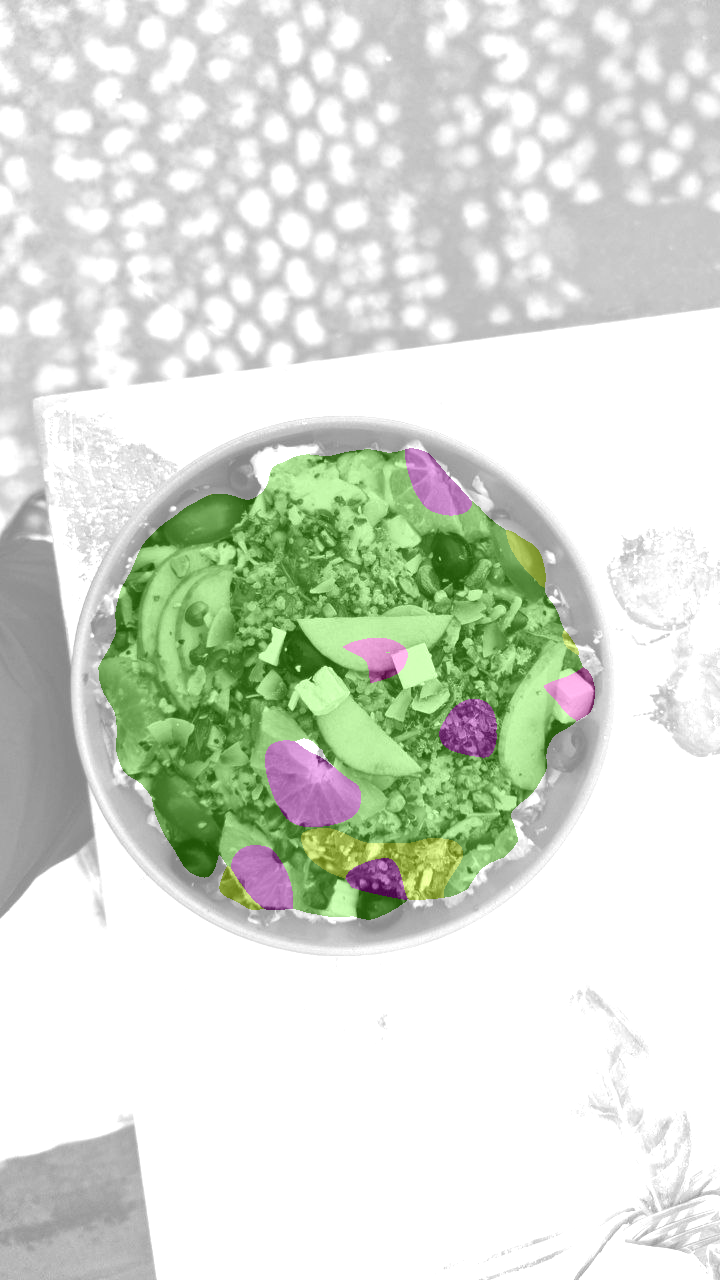

In [70]:
img

In [74]:
%load_ext line_profiler

In [77]:
%lprun -f get_image_from_url get_image_from_url(url)

Timer unit: 1e-06 s

Total time: 0.872769 s
File: /home/dima/new/mytools/mytools/tools.py
Function: get_image_from_url at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
    27                                           def get_image_from_url(url,path = None):
    28         1     578566.0 578566.0     66.3      if url: response = requests.get(url, stream=True)
    29         1          1.0      1.0      0.0      if path: pass
    30         1     294202.0 294202.0     33.7      return Image.open(response.raw)

In [76]:
%lprun -f search search(url,segment_model)

/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f1/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/tmp/ipykernel_3953353/1890443413.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clip_df = clip_df.append(df)
/tmp/ipykernel_3953353/1890443413.py:55: FutureWarning: The fr

Timer unit: 1e-06 s

Total time: 4.70994 s
File: /tmp/ipykernel_3953353/1890443413.py
Function: search at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def search(url,segment_model,stego = False, prompt_factor=0.5,min_score=0.22,exand_times =2):
     3         1    1380562.0 1380562.0     29.3      img = get_image_from_url(url)
     4         1      21020.0  21020.0      0.4      img,adj = crop_image_to_square(img,True)
     5         1          3.0      3.0      0.0      x_adj,y_adj,size = adj
     6         1          5.0      5.0      0.0      photo_id = url.split('/')[-1]
     7         1       1447.0   1447.0      0.0      i = np.asarray(img, dtype="uint8")
     8         1         59.0     59.0      0.0      i = np.flip(i,2)
     9         1     264280.0 264280.0      5.6      segmentor_mask = inference_segmentor(segment_model, i)[0]
    10         1       2372.0   2372.0      0.1      segmentor_mask[segmen

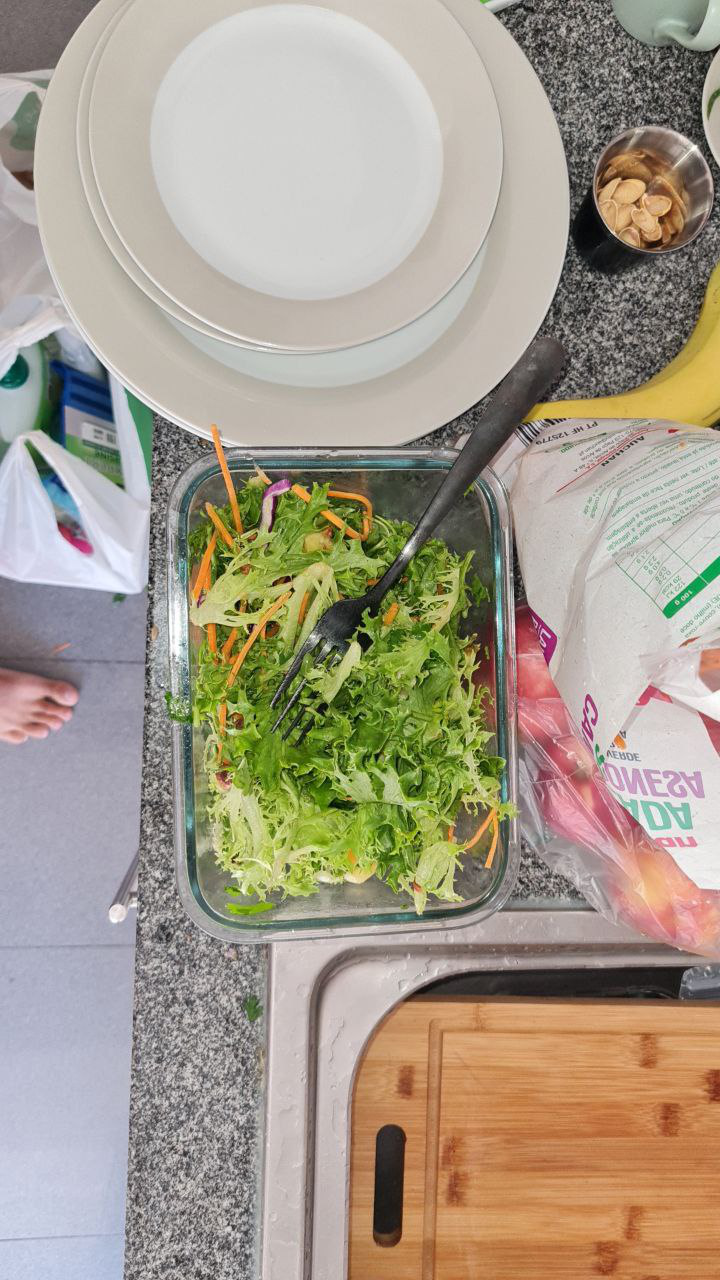

In [9]:
get_image_from_url(url)

In [14]:
search_clip(url,foods,food_clips,head=5)[1]

,id,clip,text,version,description,category,energy,protein,carb,fat,score
0,1103400,"[0.061748277, 0.052242123, -0.01560236, 0.0480...","the photo of ""Lettuce, salad with assorted ve...",1,"Lettuce, salad with assorted vegetables exclud...",Lettuce and lettuce salads,19.0,1.42,3.76,0.20,0.268600
1,1103194,"[0.021926058, 0.06655522, -0.020947428, 0.0613...","the photo of ""Carrots, raw, salad"" dish, whic...",1,"Carrots, raw, salad","Coleslaw, non-lettuce salads",208.0,1.25,17.19,15.67,0.261473
2,1103195,"[0.0426765, 0.06492045, -0.011472031, 0.050004...","the photo of ""Carrots, raw, salad with apples...",1,"Carrots, raw, salad with apples","Coleslaw, non-lettuce salads",176.0,0.84,8.16,15.95,0.258329
3,1103399,"[0.048683446, 0.05823058, -0.0016081997, 0.023...","the photo of ""Lettuce, salad with assorted ve...",1,"Lettuce, salad with assorted vegetables includ...",Lettuce and lettuce salads,20.0,1.25,4.27,0.20,0.256977
4,1099686,"[0.041277606, 0.094646685, 0.0115653, 0.005258...","the photo of ""Chicken or turkey garden salad ...",1,"Chicken or turkey garden salad with cheese, ch...",Poultry mixed dishes,91.0,10.40,2.80,4.52,0.255488


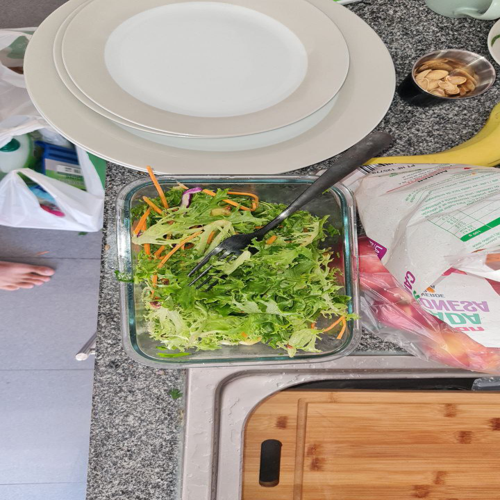

In [20]:
get_image_from_url(url).resize((500,500))

In [21]:
img,clip_df,masks,urls,stats = search(url,prompt_factor=0.1,exand_times =0)

/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(
/home/dima/anaconda3/envs/f4/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/home/dima/anaconda3/envs/f

In [22]:
clip_df

,id,clip,text,version,description,category,energy,protein,carb,fat,score,classes,area
2,1103358,"[0.05232251, 0.04803789, -0.005391314, 0.01110...","""Lettuce, raw"" made of Lettuce, green leaf, ra...",2,"Lettuce, raw",Lettuce and lettuce salads,14.0,1.13,2.92,0.14,0.291233,81,56553
0,1103857,"[0.002238046, 0.030737983, -0.010507829, 0.033...","the photo of ""Coconut oil"" dish, which is mad...",1,Coconut oil,Salad dressings and vegetable oils,833.0,0.00,0.84,99.10,0.273251,16,55986
4,1103106,"[0.043754064, 0.065489, 0.020750485, 0.0192476...","the photo of ""Romaine lettuce, raw"" dish, whi...",1,"Romaine lettuce, raw",Lettuce and lettuce salads,15.0,1.36,2.87,0.15,0.285058,92,39047
6,1098966,"[-0.02106328, 0.02855185, -0.0015888794, 0.022...","the photo of ""Salmon, baked or broiled, made ...",1,"Salmon, baked or broiled, made with cooking spray",Fish,164.0,25.72,0.20,5.92,0.227421,1,19692
3,1100826,"[0.01598605, 0.047115948, 0.02619524, 0.027829...","the photo of ""Bread, sunflower meal, toasted""...",1,"Bread, sunflower meal, toasted",Yeast breads,334.0,10.77,52.56,9.01,0.221586,85,1090
1,1101273,"[-0.0812443, -0.0276091, 0.05517517, 0.0344641...","the photo of ""Cookie, teething, baby"" dish, w...",1,"Cookie, teething, baby",Baby food: snacks and sweets,392.0,10.70,76.40,4.20,0.242810,20,715
5,1101686,"[-0.008199546, 0.017620958, 0.052234963, 0.045...","the photo of ""Oat bran cereal, cooked, NS as ...",1,"Oat bran cereal, cooked, NS as to fat",Grits and other cooked cereals,58.0,3.17,12.08,2.79,0.232467,102,480


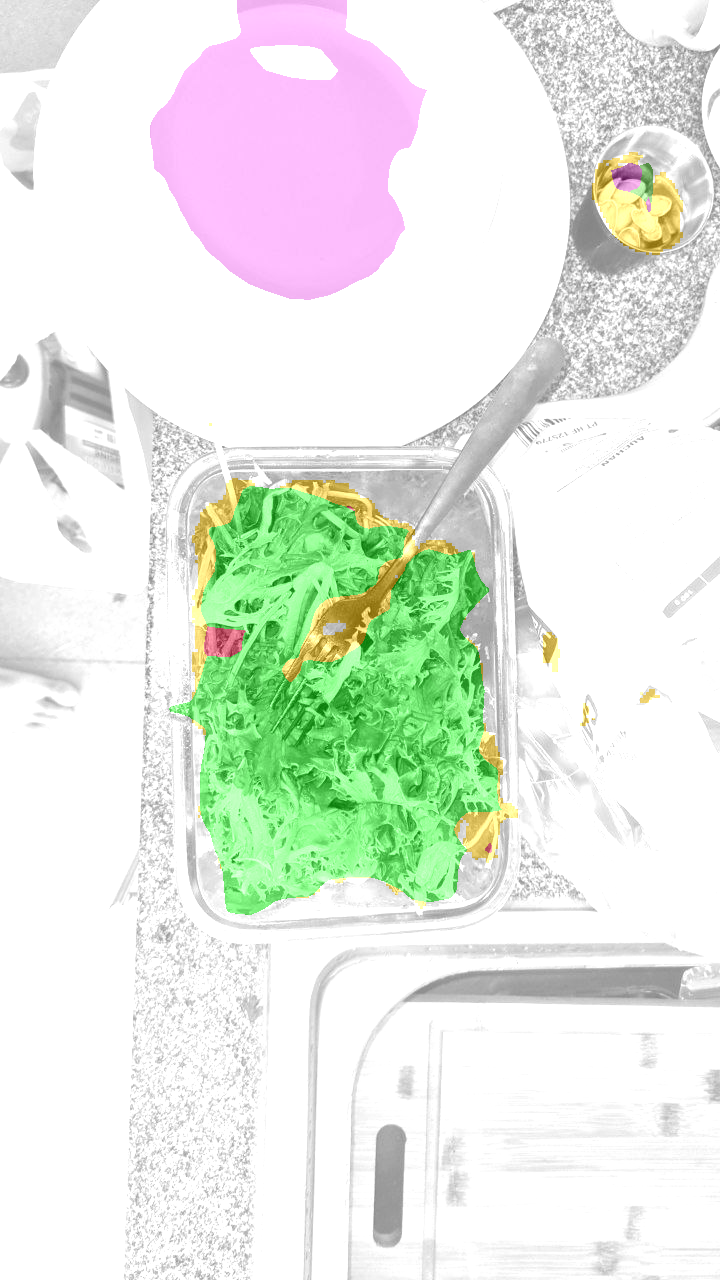

In [23]:
img

In [90]:
!conda activate f4; nbdev_build_lib


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


/bin/bash: nbdev_build_lib: command not found
